# Titanic dec tree

In [33]:
%run prepare_data.py

In [34]:
dec_tree = DecisionTreeClassifier()
skfold = StratifiedKFold(n_splits=8)
# don't know if skfold actually makes sense here
# cross_val_score(dec_tree, strat_train_prep, strat_train_labels, cv = skfold, scoring="accuracy")

In [35]:
# n_estimators_range = np.arange(1,10)
# train_scores, test_scores = validation_curve(dec_tree, strat_train_prep, strat_train_labels, param_name="n_estimators", param_range=n_estimators_range, scoring="accuracy", cv = skfold)
# plt.plot(n_estimators_range, np.mean(train_scores, 1), label="train score", c='b')
# plt.plot(n_estimators_range, np.mean(test_scores, 1), label="test score", c='r')

In [36]:
# value: scores for training and for dev test set, and clf model
clf_cols_scores = {cols : [[],None] for cols in drop_col_lists}

for drop_group in drop_col_lists.items():
    
    pips = []
    for colname in drop_group[0].split(", "):
        pips.append( (colname, cols_pipelines[colname], [colname]) )
    
    attr_pip = ColumnTransformer(pips, remainder="passthrough")
    
    strat_train =  strat_train_all.drop(drop_group[1], axis = 1)
    strat_devtest = strat_devtest_all.drop(drop_group[1], axis = 1)
    
    strat_train_prep = attr_pip.fit_transform(strat_train)
    strat_devtest_prep = attr_pip.fit_transform(strat_devtest)

    n_features = strat_train_prep.shape[1]

    param_grid = [
        {"random_state" : [42], "max_features" : [None] + list(np.arange(n_features)), "max_depth" : [None, 3,4,5,6], "max_leaf_nodes" : [None, 3],
         "min_samples_split" : [2,3], "min_samples_leaf" : [1,2,3,4]}
    ]

    gridsearch_nosvd = GridSearchCV(dec_tree, param_grid = param_grid, cv = skfold, scoring=make_scorer(f1_score),
                              return_train_score=False)
    gridsearch_nosvd.fit(strat_train_prep, strat_train_labels)
    
    
#     pred_scores = cross_val_predict(best_dec_tree_nosvd, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
#     pred = best_dec_tree_nosvd.predict(strat_train_prep)
    
#     precision = precision_score(strat_train_labels, pred)
#     recall = recall_score(strat_train_labels, pred)
#     roc_score = roc_auc_score(strat_train_labels, pred_scores[:,1])
#     conf_mat = confusion_matrix(strat_train_labels, pred)
    
#     clf_cols_scores[drop_group[0]][0][0] = [precision, recall, roc_score, conf_mat]
#     clf_cols_scores[drop_group[0]][0][2] = best_dec_tree_nosvd
    
    
###
#     pred_scores = cross_val_predict(best_dec_tree_nosvd, strat_devtest_prep, strat_devtest_labels, cv = skfold, method="predict_proba")
#     pred = best_dec_tree_nosvd.predict(strat_devtest_prep)
    
#     precision = precision_score(strat_devtest_labels, pred)
#     recall = recall_score(strat_devtest_labels, pred)
#     roc_score = roc_auc_score(strat_devtest_labels, pred_scores[:,1])
#     conf_mat = confusion_matrix(strat_devtest_labels, pred)
    
#     clf_cols_scores[drop_group[0]][0][1] = [precision, recall, roc_score, conf_mat]

    
###############
    svd_dec_tree_pip = Pipeline([
        ("svd", TruncatedSVD()),
        ("dec_tree", DecisionTreeClassifier())
    ])
     
    svd_param_grid = [
        {"svd__n_components" : [2,3], "dec_tree__random_state" : [42], "dec_tree__max_features" : [None, 2, 3], "dec_tree__max_depth" : [None, 3,4,5,6], "dec_tree__max_leaf_nodes" : [None, 3],
         "dec_tree__min_samples_split" : [2,3], "dec_tree__min_samples_leaf" : [1,2,3,4]}
    ]
    
    gridsearch_svd = GridSearchCV(svd_dec_tree_pip, param_grid = svd_param_grid, cv = skfold,
                              scoring=make_scorer(f1_score), return_train_score=False)
    gridsearch_svd.fit(strat_train_prep, strat_train_labels)
     
#     pred_scores = cross_val_predict(best_dec_tree_svd, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
#     pred = best_dec_tree_svd.predict(strat_train_prep)
    
#     precision = precision_score(strat_train_labels, pred)
#     recall = recall_score(strat_train_labels, pred)
#     roc_score = roc_auc_score(strat_train_labels, pred_scores[:,1])
#     conf_mat = confusion_matrix(strat_train_labels, pred)
    
#     clf_cols_scores[drop_group[0]][1][0] = [precision, recall, roc_score, conf_mat]
#     clf_cols_scores[drop_group[0]][1][2] = best_dec_tree_svd
    
    
###
#     pred_scores = cross_val_predict(best_dec_tree_svd, strat_devtest_prep, strat_devtest_labels, cv = skfold, method="predict_proba")
#     pred = best_dec_tree_svd.predict(strat_devtest_prep)
    
#     precision = precision_score(strat_devtest_labels, pred)
#     recall = recall_score(strat_devtest_labels, pred)
#     roc_score = roc_auc_score(strat_devtest_labels, pred_scores[:,1])
#     conf_mat = confusion_matrix(strat_devtest_labels, pred)
    
#     clf_cols_scores[drop_group[0]][1][1] = [precision, recall, roc_score, conf_mat]

    if gridsearch_nosvd.best_score_ >= gridsearch_svd.best_score_:
        clf_cols_scores[drop_group[0]][0] = gridsearch_nosvd.best_score_
        clf_cols_scores[drop_group[0]][1] = gridsearch_nosvd.best_estimator_
    else:
        clf_cols_scores[drop_group[0]][0] = gridsearch_svd.best_score_
        clf_cols_scores[drop_group[0]][1] = gridsearch_svd.best_estimator_


/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

In [37]:
best_colset_clf = sorted(clf_cols_scores.items(), key = lambda e: e[1][0], reverse=True)[0]
best_dec_tree = best_colset_clf[1][1]
best_colset_clf

('Sex, Pclass, Fare_cat, Family_size, Age_cat',
 [0.7660955343699062,
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=5, max_features=5, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=2, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=42, splitter='best')])

In [38]:
strat_train = strat_train_all.drop(drop_col_lists[best_colset_clf[0]], axis = 1)
strat_devtest = strat_devtest_all.drop(drop_col_lists[best_colset_clf[0]], axis = 1)

pips = []
for colname in best_colset_clf[0].split(", "):
    pips.append( (colname, cols_pipelines[colname], [colname]) )

attr_pip = ColumnTransformer(pips, remainder="passthrough")

strat_train_prep = attr_pip.fit_transform(strat_train)
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)

## On seen

In [39]:
pred_scores = cross_val_predict(best_dec_tree, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
pred = best_dec_tree.predict(strat_train_prep)

confusion_matrix(strat_train_labels, pred)

array([[433,  61],
       [ 72, 235]])

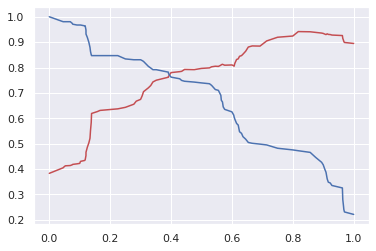

In [40]:
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

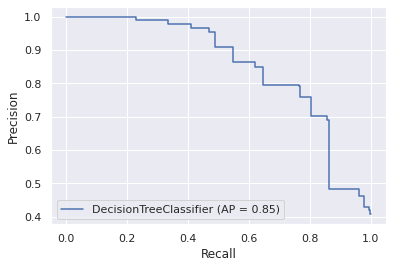

In [41]:
plot_precision_recall_curve(best_dec_tree, strat_train_prep, strat_train_labels, response_method="predict_proba")

In [42]:
roc_auc_score(strat_train_labels, pred_scores[:,1])

0.8539411043268407

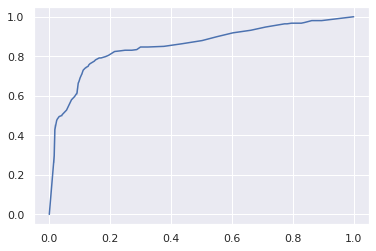

In [43]:
fpr, tpr, thresh = roc_curve(strat_train_labels, pred_scores[:, 1])
sns.lineplot(x = fpr, y = tpr)

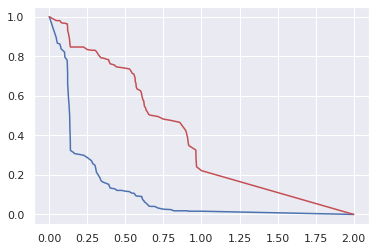

In [44]:
sns.lineplot(x = thresh, y = fpr)
sns.lineplot(x = thresh, y = tpr, color = "r")

## On unseen

In [45]:
pred_scores = best_dec_tree.predict_proba(strat_devtest_prep)
pred = best_dec_tree.predict(strat_devtest_prep)

confusion_matrix(strat_devtest_labels, pred)

array([[45, 10],
       [ 8, 27]])

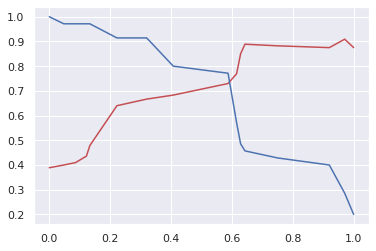

In [46]:
precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

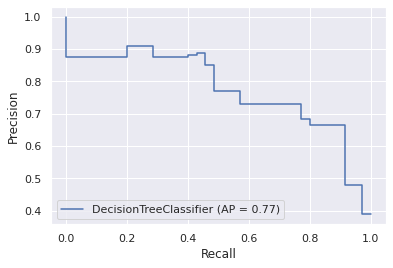

In [47]:
plot_precision_recall_curve(best_dec_tree, strat_devtest_prep, strat_devtest_labels, response_method="predict_proba")

In [48]:
roc_auc_score(strat_devtest_labels, pred_scores[:,1])

0.8618181818181818

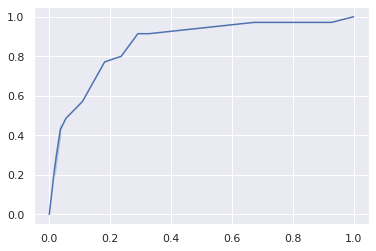

In [49]:
fpr, tpr, thresh = roc_curve(strat_devtest_labels, pred_scores[:, 1])
sns.lineplot(x = fpr, y = tpr)

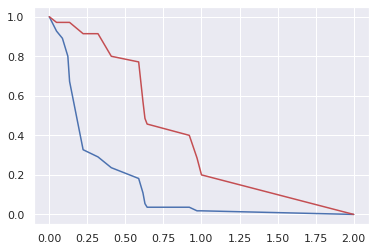

In [50]:
sns.lineplot(x = thresh, y = fpr)
sns.lineplot(x = thresh, y = tpr, color = "r")

## Custom thresholds

In [51]:
pred_scores = cross_val_predict(best_dec_tree, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores[:, 1])

thresholds[np.argmax(precisions >= 0.8)]

0.5333333333333333

In [52]:
thresh = thresholds[np.argmax(precisions >= 0.8)]
custom_thresh_preds = pred_scores > thresh
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, custom_thresh_preds[:, 1])

# sns.lineplot(thresholds, precisions[:-1], color="r")
# sns.lineplot(thresholds, recalls[:-1], color="b")
precision_score(strat_train_labels, custom_thresh_preds[:, 1])

0.8051470588235294

In [53]:
confusion_matrix(strat_train_labels, custom_thresh_preds[:,1])

array([[441,  53],
       [ 88, 219]])

# Test set

In [54]:
#best_model = RandomForestClassifier(random_state=42)
best_model = best_dec_tree

full_train = titanic.drop("Survived", axis=1)
full_train.drop(drop_col_lists[best_colset_clf[0]], axis = 1, inplace=True)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [55]:
test = pd.read_csv(fname_test)
test_orig = test

class CabinLetterTest(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=test.index, columns=test.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]


cabin_letter_pip = Pipeline([
    ("cabin_letter_pip", CabinLetterTest())
])

test = pd.DataFrame(cabin_letter_pip.fit_transform(test), index=test.index,
                       columns = test.columns.union(pd.Index(["Cabin_letter"]), sort=False))
test.loc[ (test.Pclass == 1) & test.Cabin_letter.isna(), "Cabin_letter"] = 'C'
test.loc[ (test.Pclass == 2) & test.Cabin_letter.isna(), "Cabin_letter"] = 'F'
test.loc[ (test.Pclass == 3) & test.Cabin_letter.isna(), "Cabin_letter"] = 'G'

test["Family_size"] = test.SibSp + test.Parch

s_ticket_group = test.groupby("Ticket").size().rename("Ticket_group_size")
test = test.join(s_ticket_group, on="Ticket", sort=False)

test["Fare_p_person"] = pd.Series(np.nan)
test.loc[test.Ticket_group_size == 1, "Fare_p_person"] = test.loc[test.Ticket_group_size == 1, "Fare"]
test.loc[(test.Ticket_group_size > 1), "Fare_p_person"] = \
    test.loc[(test.Ticket_group_size > 1), "Fare"] / (test.loc[(test.Ticket_group_size > 0), "Ticket_group_size"])

test.loc[152, "Fare_p_person"] = 12.0

age_round = test.Age.dropna().apply(np.floor)
test = test.join(age_round, lsuffix="_x", sort=False)
test.drop("Age_x", axis=1, inplace=True)

knnimputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

mask = test.Age.notna() & ( (test.Fare_p_person < 12) | (test.Age < 12) )
df_children_or_low_fare = test.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_low_fare = test.loc[(test.Fare_p_person < 12) & test.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_low_fare)
test.loc[(test.Fare_p_person < 12) & test.Age.isna(), "Age"] = imp[:, 2]

mask = test.Age.notna() & (test.Fare_p_person >= 12)
df_children_or_low_fare = test.loc[mask, ["Family_size", "Fare_p_person", "Age"]]
knnimputer.fit(df_children_or_low_fare)
missing_age_usual_fare = test.loc[(test.Fare_p_person >= 12) & test.Age.isna()][["Family_size", "Fare_p_person", "Age"]]
imp = knnimputer.transform(missing_age_usual_fare)
test.loc[(test.Fare_p_person >= 12) & test.Age.isna(), "Age"] = imp[:, 2]

test["Fare_cat"] = pd.cut(test.Fare_p_person, bins = [0, 13, 30, 513], include_lowest=True)

test["Age_cat"] = pd.cut(test["Age"].astype(int), bins = [-1, 20, 40, 60, 90])

test.drop(drop_col_lists[best_colset_clf[0]], axis = 1, inplace=True)


In [56]:
test_prep = attr_pip.fit_transform(test)

survival_pred = best_model.predict(test_prep)


# survival_proba = best_model.predict_proba(test_prep)
# survival_pred = survival_proba > thresh
# survival_pred = survival_pred[:, 1].astype(int)


survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test_orig.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv(fdir_out + "prediction_"  + os.path.basename(__file__) + ".csv")
id_survival

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
